# Trabajo Práctico N° 3
<br/>

## Curso de Especialización en Inteligencia Artificial
## Visión por computadora 1
<br/>

### Autor: Maximiliano Torti
### Fecha: 23/05/21
<br/>

#### Enunciado:<br/>
Para la imagen suministrada "eyes"(por ninguna razón en especial, con heterocromía), implementar un
algoritmo que:
1. Encuentre la posición de los iris en cada par de ojos y mida su distancia en píxeles
2. Encuentre la posición de las pupilas en cada par de ojos y mida su distancia en píxeles

<div style="clear: both">
<img src="img/eyes.jpg" style="width: 600px;float:left">
</div>

<div style="clear: both">
</div>


In [1]:
#Importamos librerías
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import cv2 as cv

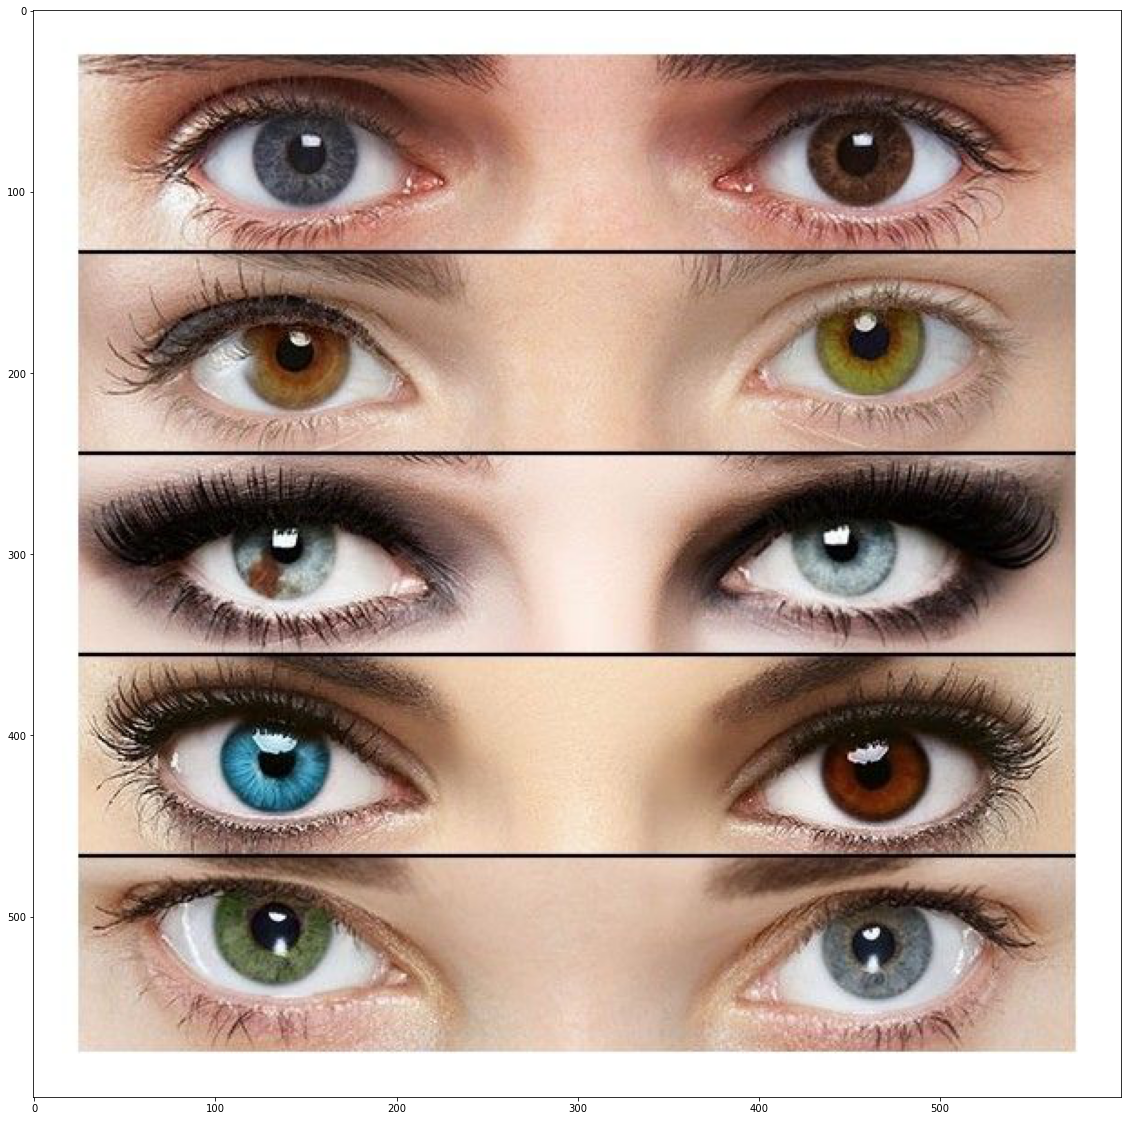

In [56]:
#Cargamos la imagen
eyes = cv.imread('img/eyes.jpg')
eyes_gray = cv.cvtColor(eyes, cv.COLOR_BGR2GRAY)
eyes_rgb=cv.cvtColor(eyes, cv.COLOR_BGR2RGB)
plt.figure(figsize=(40,20))
plt.imshow(eyes_rgb)
plt.grid(False)
plt.show()

### Apartado 1

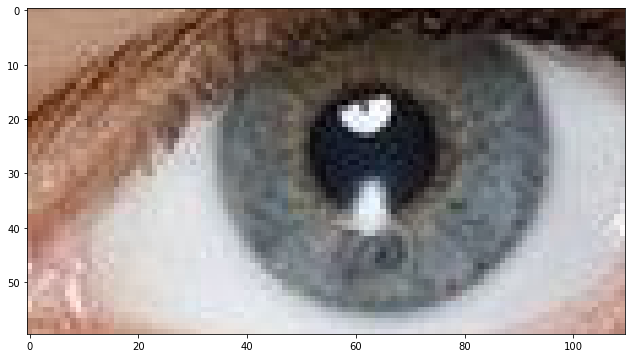

In [3]:
# Aplicamos zoom a la imagen para obtener los radios de iris
plt.figure(figsize=(20,6))
plt.imshow(eyes_rgb[490:550,400:510,:])
plt.grid(False)
plt.show()

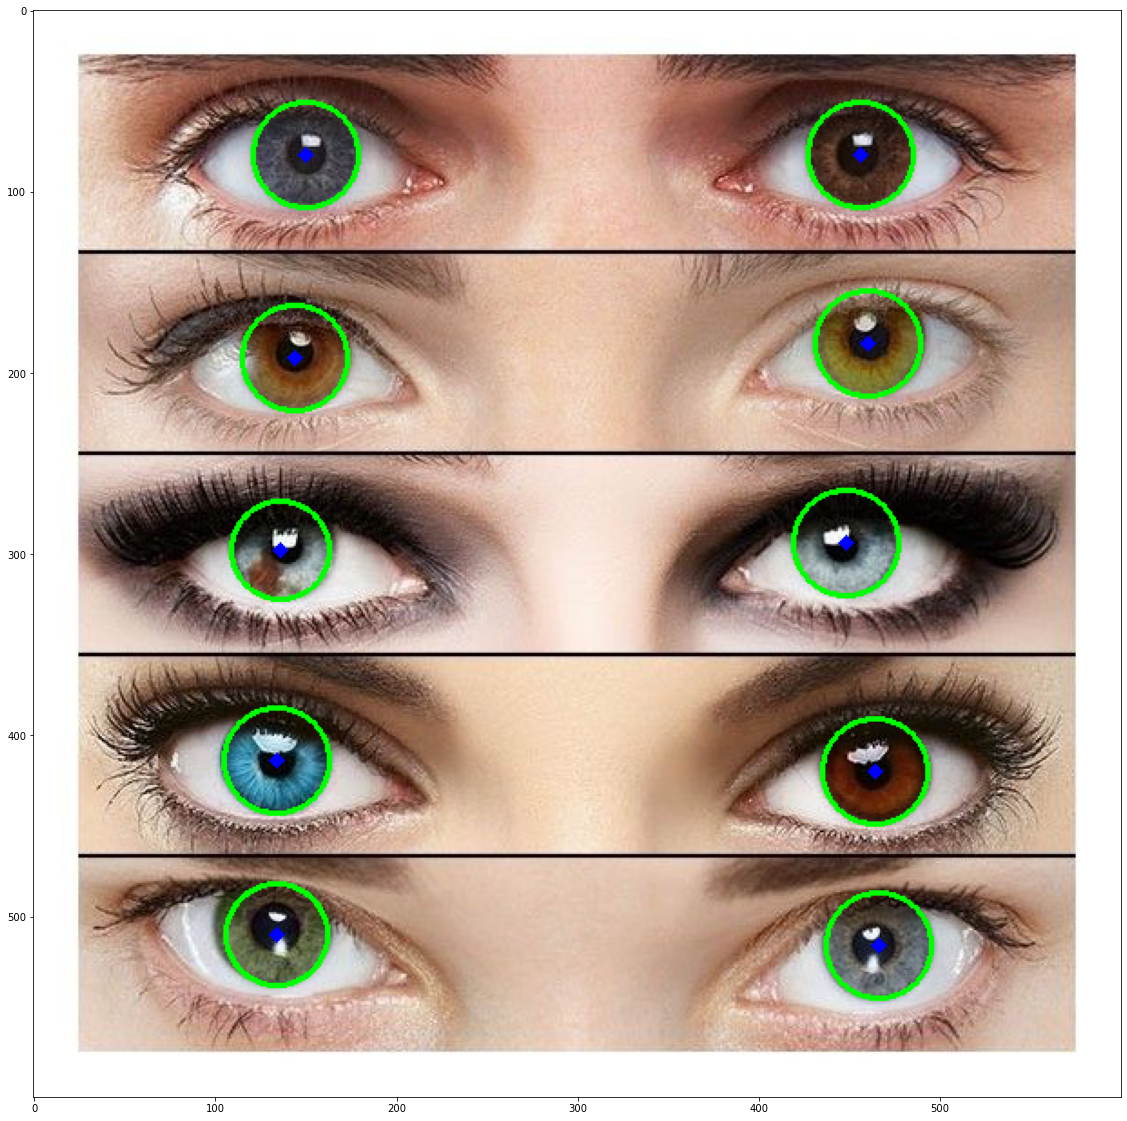

In [54]:
# Obtenemos los iris por la transformada de Hough
""" 
Parametrizacion
    image: eyes_gray
    method: cv.HOUGH_GRADIENT
    dp: resolución acumulador (1)
    minDist: minima distancia entre centros de círculos. En este caso 70 pixeles
    param1: Umbral para detector de canny. 
    param2: umbral de acumulador para detección de circulos
    minRadius: radio mínimo circulo. Aprox 20 px
    maxRadius: radio máximo circulo. Aprox 3 px
"""
# Modificamos los parámetreos hasta obtener la detección correcta de los iris
iris_rgb= eyes_rgb.copy()
iris = cv.HoughCircles(eyes_gray,cv.HOUGH_GRADIENT,1,minDist=50,param1=100,param2=16,\
                       minRadius=26,maxRadius=30)

iris = np.uint16(np.around(iris))
for i in iris[0,:]:
    cv.circle(iris_rgb,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(iris_rgb,(i[0],i[1]),2,(0,0,255),3)

plt.figure(figsize=(40,20))
plt.imshow(iris_rgb)
plt.grid(False)
plt.show()

### Nota
En la práctica fue necesario realizar muchas modificaciones de los parámetros de Hough hasta dar con la combinación que mejor detecta los iris. 

<br/>

Sería mejor realizar un pre-procesamiento. Como ideas, se podría encuadrar las áreas de interés para eliminar el "ruido" que causan las pestañas. Otra idea sería detectar bordes desde blancos casi puros (la esclerótica es prácticamente blanca).

In [5]:
def distances(x1,y1,x2,y2):
    return np.power(np.power(np.abs(x2-x1),2)+np.power(np.abs(y2-y1),2),1/2)

In [6]:
# Aplicamos matemática para determinar la distancia entre los centros de los ojos en pixeles

# Ordenamos los centros en base a la posición del Eje Y
iris_ordered=iris[:,np.argsort(iris[0,:,1])]
iris_ordered= iris_ordered.astype(np.float32)

# Calculamos la distancia entre puntos sucesivos (Y mas cercano) y creamos el vector de distancias
iris_distances=[distances(iris_ordered[0,2*i,0], \
                          iris_ordered[0,2*i,1], \
                          iris_ordered[0,2*i+1,0], \
                          iris_ordered[0,2*i+1,1])  for i in range(round(iris.shape[1]/2))]
    

In [7]:
# Resultados
print(iris_distances)

[306.0, 316.10124960208555, 312.0256399721023, 330.0545409474016, 332.05421244128195]


### Apartado 2

Notamos que en este caso es extremadamente dificil encontrar las pupilas ajustando el algoritmo de Hough. Para simplificar la tarea, aprovechamos el resultado del ejercicio anterior para aplicar una "máscara".

In [34]:
# Filtro de Máscara con cirulos
pupils_mask=eyes_gray.copy()*0
for i in range(pupils_mask.shape[0]):
    for j in range(pupils_mask.shape[1]):
        for k in range(iris.shape[1]):
            if distances(i,j,iris[0,k,0],iris[0,k,1])<iris[0,k,2]:
                pupils_mask[j,i]=eyes_gray[j,i]

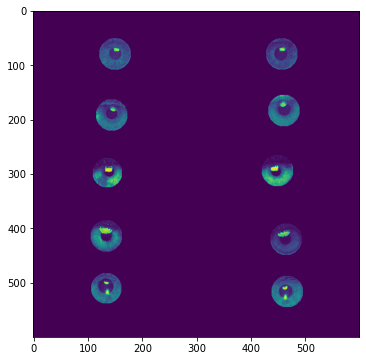

In [35]:
#Chequeamos el resultado
plt.figure(figsize=(20,6))
plt.imshow(pupils_mask)
plt.grid(False)
plt.show()

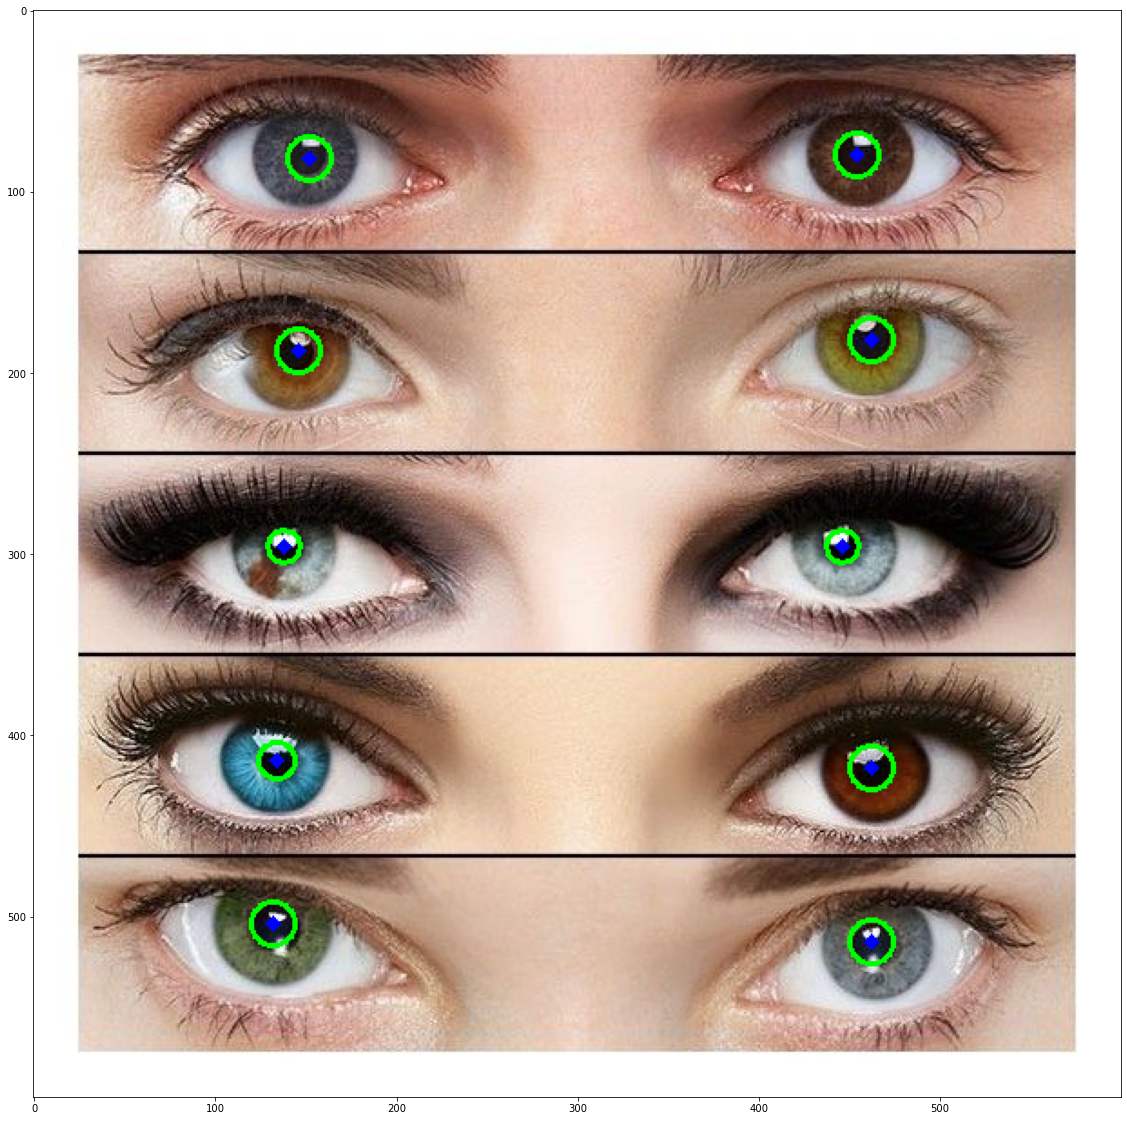

In [85]:
# Ahora si aplicamos transformada de Hough
# Modificamos los parámetreos hasta obtener la detección correcta de las pupilas
pupils_rgb= eyes_rgb.copy()
pupils = cv.HoughCircles(pupils_mask,cv.HOUGH_GRADIENT,1,minDist=30,param1=90,param2=14,\
                       minRadius=6,maxRadius=13)

pupils = np.uint16(np.around(pupils))
for i in pupils[0,:]:
    cv.circle(pupils_rgb,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(pupils_rgb,(i[0],i[1]),2,(0,0,255),3)

plt.figure(figsize=(40,20))
plt.imshow(pupils_rgb)
plt.grid(False)
plt.show()

In [88]:
# Aplicamos matemática para determinar la distancia entre los centros de las pupilas en pixeles

# Ordenamos los centros en base a la posición del Eje Y
pupils_ordered=pupils[:,np.argsort(pupils[0,:,1])]
pupils_ordered= pupils_ordered.astype(np.float32)

# Calculamos la distancia entre puntos sucesivos (Y mas cercano) y creamos el vector de distancias
pupils_distances=[distances(pupils_ordered[0,2*i,0], \
                            pupils_ordered[0,2*i,1], \
                            pupils_ordered[0,2*i+1,0], \
                            pupils_ordered[0,2*i+1,1])  for i in range(round(pupils.shape[1]/2))]
    

In [89]:
# Resultados
print(pupils_distances)

[302.00662244394573, 316.0569568922665, 308.0, 328.0243893371345, 330.15148038438355]


Notamos que en ambos casos las distancias son muy parecidas, lo cual es coherente si la pupila se encuentra centrada respecto al iris